In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from IPython.display import display

In [33]:
df = pd.read_csv('Preprocess/cdf_update.csv')
df.describe()

,loan_amnt,funded_amnt,term,int_rate,installment,annual_inc,verification_status,loan_status,dti,delinq_2yrs,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,60000.000000,60000.000000,60000.000000,60000.00000,60000.00000,6.000000e+04,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,6.000000e+04,60000.000000,60000.00000,6.000000e+04
mean,15236.844583,15236.844583,42.949200,14.17415,463.98301,7.914053e+04,0.739133,0.500000,19.515371,0.378717,...,0.095750,2.400900,93.545918,44.261298,0.150533,0.076500,1.698555e+05,54599.111717,20899.84090,4.785434e+04
std,9020.746348,9020.746348,10.885375,5.28025,277.42481,8.746073e+04,0.439111,0.500004,8.951619,0.989616,...,0.563016,2.020498,9.328731,36.226314,0.414298,0.436789,1.721338e+05,50098.120757,20447.51382,4.578129e+04
min,1000.000000,1000.000000,36.000000,5.32000,30.12000,3.600000e+03,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,8.300000,0.000000,0.000000,0.000000,2.500000e+03,0.000000,100.00000,0.000000e+00
25%,8000.000000,8000.000000,36.000000,10.75000,261.88000,4.884900e+04,0.000000,0.000000,13.080000,0.000000,...,0.000000,1.000000,90.500000,0.000000,0.000000,0.000000,5.207375e+04,24073.500000,7900.00000,1.913100e+04
50%,13800.000000,13800.000000,36.000000,13.49000,393.60500,6.644950e+04,1.000000,0.500000,18.960000,0.000000,...,0.000000,2.000000,97.000000,40.000000,0.000000,0.000000,1.075195e+05,41372.000000,14800.00000,3.652400e+04
75%,20000.000000,20000.000000,60.000000,17.27000,617.46000,9.400000e+04,1.000000,1.000000,25.610000,0.000000,...,0.000000,3.000000,100.000000,75.000000,0.000000,0.000000,2.437000e+05,68407.750000,26800.00000,6.318525e+04
max,40000.000000,40000.000000,60.000000,30.99000,1584.90000,7.582566e+06,1.000000,1.000000,293.000000,29.000000,...,29.000000,29.000000,100.000000,100.000000,8.000000,15.000000,9.999999e+06,963229.000000,520500.00000,1.204116e+06


### Feature Selection

In [34]:
df.dtypes

loan_amnt                       int64
funded_amnt                     int64
term                            int64
int_rate                      float64
installment                   float64
grade                          object
emp_title                      object
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status             int64
issue_d                        object
loan_status                     int64
purpose                        object
zip_code                       object
addr_state                     object
dti                           float64
delinq_2yrs                     int64
earliest_cr_line               object
pub_rec                         int64
revol_util                    float64
total_pymnt                   float64
total_pymnt_inv               float64
last_pymnt_d                   object
last_pymnt_amnt               float64
last_credit_pull_d             object
application_

In [35]:
cor = df.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.55) | (cor < -0.55)]

funded_amnt                 loan_amnt                1.000000
installment                 loan_amnt                0.949723
                            funded_amnt              0.949723
total_pymnt                 loan_amnt                0.733923
                            funded_amnt              0.733923
                            installment              0.725121
total_pymnt_inv             loan_amnt                0.733957
                            funded_amnt              0.733957
                            installment              0.725086
                            total_pymnt              0.999994
last_pymnt_amnt             total_pymnt              0.613672
                            total_pymnt_inv          0.613691
avg_cur_bal                 tot_cur_bal              0.837963
bc_open_to_buy              total_rev_hi_lim         0.637929
bc_util                     revol_util               0.851591
mo_sin_rcnt_tl              mo_sin_rcnt_rev_tl_op    0.579016
mths_sin

In [36]:
columns_to_drop = ['funded_amnt', 'installment', 'revol_util', 'tot_cur_bal', 'zip_code', 
                   'emp_title', 'num_actv_bc_tl', 'num_op_rev_tl', 'num_sats', 'tot_hi_cred_lim', 'num_tl_30dpd',
                  'total_pymnt', 'total_pymnt_inv', 'num_rev_tl_bal_gt_0', 'tot_cur_bal', 'total_bal_ex_mort',
                  'num_bc_tl', 'percent_bc_gt_75', 'total_bc_limit', 'num_tl_op_past_12m', 'addr_state','application_type']
df = df.drop(columns_to_drop, axis=1)

In [37]:
# Extract 'year' and 'month' from all the date variables
def extract_year(df, column):
    df[column] = pd.to_datetime(df[column])
    df['{}_year'.format(column)] = pd.DatetimeIndex(df[column]).year
    df['{}_month'.format(column)] = pd.DatetimeIndex(df[column]).month
    return df

date_columns = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
# df= extract_year(df, 'issue_d')
# df = extract_year(df, 'earliest_cr_line')
# df = extract_year(df, 'last_pymnt_d')
# df = extract_year(df, 'last_credit_pull_d')

# Drop all the date variables
df = df.drop(date_columns, axis=1)

In [38]:
cor = df.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.55) | (cor < -0.55)]

bc_open_to_buy              total_rev_hi_lim         0.637929
mo_sin_rcnt_tl              mo_sin_rcnt_rev_tl_op    0.579016
mths_since_recent_bc        mo_sin_rcnt_rev_tl_op    0.618659
num_bc_sats                 num_actv_rev_tl          0.671499
num_rev_accts               num_actv_rev_tl          0.598433
                            num_bc_sats              0.595717
num_tl_90g_dpd_24m          delinq_2yrs              0.659303
pct_tl_nvr_dlq              num_accts_ever_120_pd   -0.592729
pub_rec_bankruptcies        pub_rec                  0.640773
tax_liens                   pub_rec                  0.693659
total_il_high_credit_limit  num_il_tl                0.556375
dtype: float64

### Data Transformation

In [39]:
# Convert emp_length into numeric variables
df.replace('n/a', np.nan,inplace=True)
df.emp_length.fillna(value=0,inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['emp_length'] = df['emp_length'].astype(int)

In [40]:
# Convert grade into numeric variables
df['grade'] = df['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})

In [41]:
df["home_ownership"] = df["home_ownership"].map({"MORTGAGE":6,"RENT":5,"OWN":4,"OTHER":3,"NONE":2,"ANY":1})

In [42]:
df['hardship_flag'] = df['hardship_flag'].map({'N': 0, 'Y': 1})
df['debt_settlement_flag'] = df['debt_settlement_flag'].map({'N': 0, 'Y': 1})

In [43]:
df['purpose'].value_counts()

debt_consolidation    35458
credit_card           11738
home_improvement       4080
other                  3862
major_purchase         1397
small_business          823
medical                 757
car                     574
moving                  487
vacation                448
house                   332
renewable_energy         44
Name: purpose, dtype: int64

In [44]:
# Convert categorical variables into dummy
df_dum = pd.get_dummies(df, columns = ['purpose'],drop_first = True)
df_dum.describe()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,dti,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation
count,60000.000000,60000.000000,60000.00000,60000.000000,60000.000000,60000.000000,6.000000e+04,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,15236.844583,42.949200,14.17415,5.020883,6.042483,5.345533,7.914053e+04,0.739133,0.500000,19.515371,...,0.590967,0.068000,0.005533,0.023283,0.012617,0.008117,0.064367,0.000733,0.013717,0.007467
std,9020.746348,10.885375,5.28025,1.311046,3.598777,0.675560,8.746073e+04,0.439111,0.500004,8.951619,...,0.491660,0.251748,0.074181,0.150803,0.111614,0.089727,0.245407,0.027070,0.116313,0.086087
min,1000.000000,36.000000,5.32000,1.000000,1.000000,4.000000,3.600000e+03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8000.000000,36.000000,10.75000,4.000000,2.000000,5.000000,4.884900e+04,0.000000,0.000000,13.080000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13800.000000,36.000000,13.49000,5.000000,6.000000,5.000000,6.644950e+04,1.000000,0.500000,18.960000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,20000.000000,60.000000,17.27000,6.000000,10.000000,6.000000,9.400000e+04,1.000000,1.000000,25.610000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,40000.000000,60.000000,30.99000,7.000000,10.000000,6.000000,7.582566e+06,1.000000,1.000000,293.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
df_dum['loan_status'].value_counts()

1    30000
0    30000
Name: loan_status, dtype: int64

In [453]:
loan_0 = df_dum[df_dum["loan_status"]==0]
loan_1 = df_dum[df_dum["loan_status"]==1]
subset_loan_0 = loan_0.sample(n=4800)
subset_loan_1 = loan_1.sample(n=4800)
df_clean = pd.concat([subset_loan_1, subset_loan_0])
df_clean = df_clean.sample(frac=1).reset_index(drop=True)

### Prepare date for logistic regression

In [52]:
train, test = train_test_split(df_dum, test_size = .5, random_state = 123)
y_train = train.loan_status
y_test = test.loan_status
x_train = train.drop('loan_status', axis = 1)
x_test = test.drop('loan_status', axis = 1)

In [53]:
def stand_scale(train_df, val_df, columns_to_scale):
    sc = StandardScaler().fit(train_df[columns_to_scale])
    train_df[columns_to_scale] = sc.transform(train_df[columns_to_scale])
    val_df[columns_to_scale] = sc.transform(val_df[columns_to_scale])
    return train_df, val_df

In [54]:
x_train.columns[0:38]

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'dti',
       'delinq_2yrs', 'pub_rec', 'last_pymnt_amnt', 'acc_now_delinq',
       'tot_coll_amt', 'total_rev_hi_lim', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_rev_tl',
       'num_bc_sats', 'num_il_tl', 'num_rev_accts', 'num_tl_120dpd_2m',
       'num_tl_90g_dpd_24m', 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies',
       'tax_liens', 'total_il_high_credit_limit'],
      dtype='object')

In [55]:
# Standardize scale un-binary columns
nonbin_columns = list(x_train)[0:38]
nonbin_columns.remove('verification_status')
x_train_scaled, x_test_scaled = stand_scale(x_train, x_test, nonbin_columns)
x_train_scaled.describe()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,dti,delinq_2yrs,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation
count,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,30000.000000,3.000000e+04,3.000000e+04,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,1.788261e-16,1.651272e-17,-5.389430e-16,-9.213630e-16,-1.622547e-15,6.739054e-17,-1.801448e-16,0.740500,2.513582e-16,8.418858e-16,...,0.587567,0.068833,0.005367,0.024700,0.012767,0.008267,0.065067,0.000667,0.013867,0.007767
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,0.438368,1.000017e+00,1.000017e+00,...,0.492281,0.253175,0.073062,0.155212,0.112268,0.090546,0.246648,0.025812,0.116939,0.087787
min,-1.576201e+00,-6.399293e-01,-1.685914e+00,-3.078834e+00,-1.413284e+00,-1.983331e+00,-9.076327e-01,0.000000,-2.240833e+00,-3.812885e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.019257e-01,-6.399293e-01,-6.528114e-01,-7.806440e-01,-1.135022e+00,-5.080041e-01,-3.801391e-01,0.000000,-7.391801e-01,-3.812885e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.382613e-01,-6.399293e-01,-1.315036e-01,-1.458074e-02,-2.197343e-02,-5.080041e-01,-1.573525e-01,1.000000,-6.079179e-02,-3.812885e-01,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.254031e-01,1.562673e+00,5.876728e-01,7.514825e-01,1.091075e+00,9.673225e-01,1.918419e-01,1.000000,7.049821e-01,-3.812885e-01,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.737618e+00,1.562673e+00,3.198017e+00,1.517546e+00,1.091075e+00,9.673225e-01,9.537667e+01,1.000000,7.901647e+00,2.940420e+01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature Selection
#### Recursive Feature Elimination:      
A type of wrapper feature selection method.    
The Recursive Feature Elimination (or RFE) works by recursively removing attributes and building a model on those attributes that remain.   
It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

In [56]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [57]:
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [58]:
logreg = LogisticRegression(C=1e30)
logreg.fit(x_train_scaled, y_train)
rfe = RFE(logreg, 25)
fit = rfe.fit(x_train_scaled, y_train.values.ravel())
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 25
Selected Features: [ True  True  True  True False False  True  True False  True False  True
 False False False  True False  True False False False False  True False
  True  True False False  True  True False False False False False  True
 False False  True  True False  True False False  True  True  True False
  True  True  True]
Feature Ranking: [ 1  1  1  1 11  2  1  1 17  1 16  1 27 26 14  1 10  1  7 21 24 12  1 18
  1  1 19 25  1  1  5  9 22  8 23  1 15  6  1  1  4  1  3 20  1  1  1 13
  1  1  1]


In [59]:
rfe_var = fit.support_
rfe_var_index = np.where(rfe_var == True)[0]
x_col = x_train.columns
rfe_var = x_col[rfe_var_index]
rfe_var

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'annual_inc',
       'verification_status', 'delinq_2yrs', 'last_pymnt_amnt',
       'acc_open_past_24mths', 'bc_open_to_buy', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'num_actv_rev_tl', 'num_bc_sats',
       'pub_rec_bankruptcies', 'hardship_flag', 'debt_settlement_flag',
       'purpose_debt_consolidation', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_renewable_energy',
       'purpose_small_business', 'purpose_vacation'],
      dtype='object')

In [60]:
from sklearn.metrics import accuracy_score

x_train_rfe = x_train_scaled[rfe_var]
x_test_rfe = x_test_scaled[rfe_var]
logreg_rfe = LogisticRegression(C=1)
logreg_rfe.fit(x_train_rfe, y_train)
y_pred_rfe = logreg_rfe.predict(x_test_rfe)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(accuracy_score(y_test, y_pred_rfe)))

Accuracy of logistic regression classifier on test set: 0.76


Text(0,0.5,'Cumulative Variance')

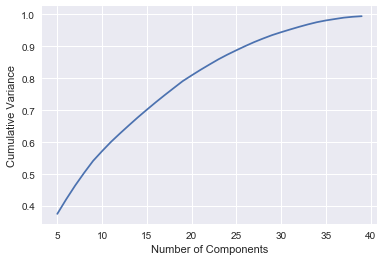

In [61]:
cum_variance = []
for n in range(5,40):
    pca_transformer = PCA(n).fit(x_train_scaled)
    x_train_2d = pca_transformer.transform(x_train_scaled)
    cum_variance.append(sum(pca_transformer.explained_variance_ratio_))

plt.plot(range(5,40), cum_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')

In [62]:
# number of component=23
pca_transformer_23 = PCA(20).fit(x_train_scaled)
x_train_2d_23 = pca_transformer_23.transform(x_train_scaled)
x_test_2d_23 = pca_transformer_23.transform(x_test_scaled)
# number of component=28
pca_transformer_28 = PCA(30).fit(x_train_scaled)
x_train_2d_28 = pca_transformer_28.transform(x_train_scaled)
x_test_2d_28 = pca_transformer_28.transform(x_test_scaled)
# fit logistic model
fitted_lr_23 = LogisticRegression(C=0.1).fit(x_train_2d_23,y_train)
fitted_lr_28 = LogisticRegression(C=0.1).fit(x_train_2d_28,y_train)
y_test_predicted_lr_23 = fitted_lr_23.predict(x_test_2d_23)
y_test_predicted_lr_28 = fitted_lr_28.predict(x_test_2d_28)
print("Training set score when number of component is 23:", fitted_lr_23.score(x_train_2d_23,y_train))
print("Test set score when number of component is 23:", fitted_lr_23.score(x_test_2d_23,y_test))
print("Training set score when number of component is 28:", fitted_lr_28.score(x_train_2d_28,y_train))
print("Test set score when number of component is 28:", fitted_lr_28.score(x_test_2d_28,y_test))

Training set score when number of component is 23: 0.7058666666666666
Test set score when number of component is 23: 0.7078333333333333
Training set score when number of component is 28: 0.7489333333333333
Test set score when number of component is 28: 0.7487666666666667


In [63]:
from sklearn.model_selection import GridSearchCV

c=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(C=c)
logreg = LogisticRegression()
grid = GridSearchCV(logreg, param_grid,cv=10, scoring='accuracy')
grid.fit(x_train_scaled, y_train)
mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
print("Best accuracy is "+ str(grid.best_score_))
print(grid.best_estimator_)

Best accuracy is 0.7574
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [64]:
logreg = LogisticRegression(C = grid.best_estimator_.C).fit(x_train_scaled,y_train)
y_logreg = logreg.predict(x_test_scaled)
logreg_score = accuracy_score(y_test, y_logreg)
logreg_score

0.7606666666666667

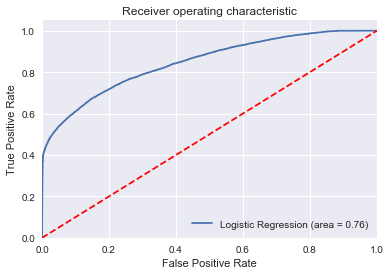

In [65]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test_scaled))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test_scaled)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()